Training image shape: (10000, 32, 32, 3)
Test image shape: (10000, 32, 32, 3)


<ipython-input-2-895d52460485>:65: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 259ms/step - accuracy: 0.1727 - loss: 2.9643 - val_accuracy: 0.1368 - val_loss: 2.6873
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.3679 - loss: 2.1958 - val_accuracy: 0.2931 - val_loss: 2.3550
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.4615 - loss: 1.9655 - val_accuracy: 0.4588 - val_loss: 1.9290
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.4989 - loss: 1.8253 - val_accuracy: 0.5363 - val_loss: 1.7243
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.5511 - loss: 1.6871 - val_accuracy: 0.5694 - val_loss: 1.6366
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.5752 - loss: 1.6122 - val_accuracy: 0.5874 - val_loss: 1.6252
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.6039 - loss: 1.5251 - val_accuracy: 0.6088 - val_loss: 1.5529
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.6241 - loss: 1.4699 - val_accuracy: 0.622

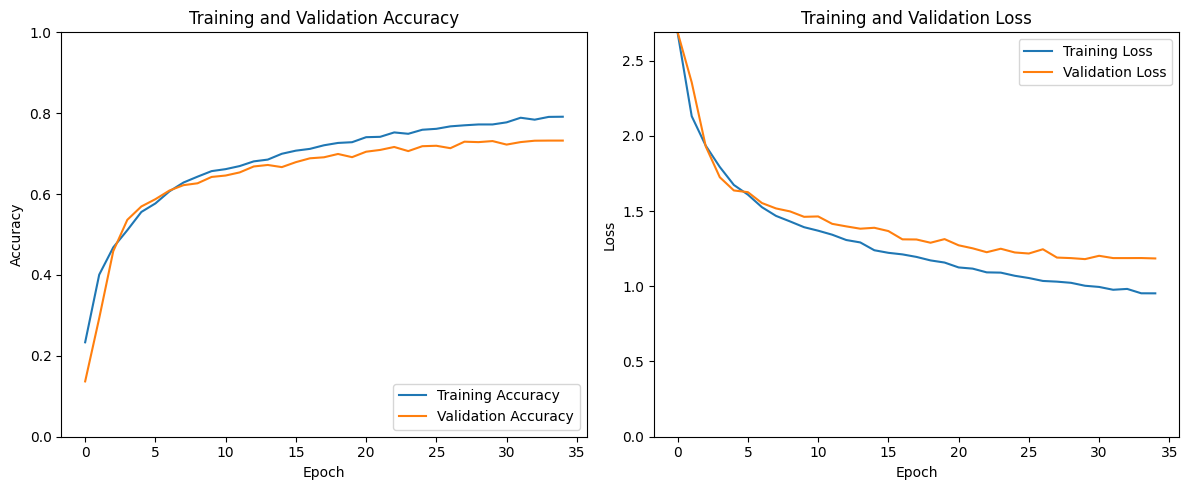

79/79 - 1s - 7ms/step - accuracy: 0.7311 - loss: 1.1802

Test accuracy: 73.11% 
Test Loss: 118.02%


In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Function to unpickle the dataset manually
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Path to a single batch (e.g., data_batch_1) and the test batch
batch_path = r"C:\Users\ravi\Desktop\ML Algorithms\Datasets\cifar-10-batches-py\data_batch_1"
test_batch_path = r"C:\Users\ravi\Desktop\ML Algorithms\Datasets\cifar-10-batches-py\test_batch"

# Function to load a single batch and test data
def load_cifar10(batch_path, test_batch_path):
    # Load the single training batch
    batch_data = unpickle(batch_path)
    x_train = batch_data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype('float32')
    y_train = np.array(batch_data[b'labels'])

    # Load the test batch
    test_batch = unpickle(test_batch_path)
    x_test = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype('float32')
    y_test = np.array(test_batch[b'labels'])

    # Print the shape of the training and testing images
    print(f'Training image shape: {x_train.shape}')  # (num_samples, height, width, channels)
    print(f'Test image shape: {x_test.shape}')

    return (x_train, y_train), (x_test, y_test)

# Load the CIFAR-10 dataset manually (only one batch for training)
(x_train, y_train), (x_test, y_test) = load_cifar10(batch_path, test_batch_path)

# Normalize pixel values between -1 and 1 for MobileNet
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

# Apply data augmentation on the training set
train_generator = train_datagen.flow(x_train, y_train, batch_size=128)

# No augmentation for the test set
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(x_test, y_test, batch_size=128)

# Define the MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set up early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=test_generator,
                    callbacks=[early_stopping])

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(max(history.history['loss']), max(history.history['val_loss']))])
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'\nTest accuracy: {test_acc * 100:.2f}% \nTest Loss: {test_loss * 100:.2f}%')
